In [ ]:
import pickle as pkl
import pandas as pd
import aegnn
import torch
import torch_geometric

import argparse
import logging
import os
import numpy as np
import pandas as pd
import pytorch_lightning.metrics.functional as pl_metrics

from torch_geometric.data import Batch
from torch_geometric.utils import subgraph
from typing import Iterable, Tuple

from torch_geometric.data import Data
from tqdm import tqdm
from typing import List
from torch.nn import Linear
from torch.nn.functional import elu
from torch_geometric.nn.conv import SplineConv
from torch_geometric.nn.norm import BatchNorm
from torch_geometric.transforms import Cartesian

For 4000 samples, wrt their own events/nodes:
```
acc_Mflop_per_ev = 134.74224981457488, avg_Mflop_per_ev = 0.03368556245364372
dense: std acc_Mflop_per_ev = 1170.527851753108, std avg_Mflop_per_ev = 0.29263196293827703
```

For 100 samples, wrt their own events/nodes:
```
acc_Mflop_per_ev = 3.414027443525552, avg_Mflop_per_ev = 0.034140274435255524
dense: std acc_Mflop_per_ev = 28.595094207357473, std avg_Mflop_per_ev = 0.28595094207357474
```

Corrected formula for calculating FLOPS (according to updated paper), leading to:

For 4000 samples, wrt their own events/nodes:
```
acc_Mflop_per_ev = 240.93893365788432, avg_Mflop_per_ev = 0.06023473341447108
dense: std acc_Mflop_per_ev = 2096.876591199398, std avg_Mflop_per_ev = 0.5242191477998495
```

In [ ]:
data_module = aegnn.datasets.NCars(batch_size=1, shuffle=False)
data_module.setup()
dm = data_module.train_dataset

# cnt = 0
# for i, dms in enumerate(dm):
#     cnt += 1
#     print(i)

# print(cnt)

# num_trials=100
# nodes=[]
# nodes_cnt=0
# for index in tqdm(range(num_trials)):
#     sample = dm[index % len(dm)]
#     nodes.append(sample.num_nodes)
#     nodes_cnt += sample.num_nodes
# print(nodes_cnt)

print(dm.dims)

In [ ]:
import wandb
from wandb import sdk as wandb_sdk

wandb.init(project="aegnn", entity="yyfteam")
# log_settings = wandb.Settings(start_method="thread")
log_settings = wandb.Settings(start_method="fork")
wandb_sdk.Settings()

In [ ]:
import aegnn
import torch
import torch_geometric

edge_attr = torch_geometric.transforms.Cartesian(cat=False, max_value=10.0)

print(type(edge_attr))

In [ ]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR

initial_lr = 0.5



class model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3)

    def forward(self, x):
        pass

net_1 = model()

def LRPolicy(epoch):
    if epoch < 2:
        return 1
    else:
        return 0.1

optimizer_1 = torch.optim.Adam(net_1.parameters(), lr = initial_lr)
scheduler_1 = LambdaLR(optimizer_1, lr_lambda=LRPolicy)

print("init lr", optimizer_1.defaults['lr'])

for epoch in range(1, 11):
    # train
    optimizer_1.zero_grad()
    optimizer_1.step()
    print("lr of %dth epoch: %f" % (epoch, optimizer_1.param_groups[0]['lr']))
    scheduler_1.step()

In [ ]:
import os
import shutil
import glob
import sys

path='../aegnn_results/training_results/latest'
if not os.path.exists(path):
    os.makedirs(path)
else:
    # clean
    try:
        shutil.rmtree(path)
    except OSError as e:
        print("Error: %s : %s" % (path, e.strerror))
    
    # rebuild
    os.makedirs(path)

src_model = sorted(glob.glob(r'/space/yyang22/datasets/data/scratch/checkpoints/ncars/recognition/*/*.pt'), key=os.path.getctime)[-1]
dst_model = os.path.join(path,'latest_model.pt')

src_log = sorted(glob.glob(r'/space/yyang22/datasets/data/scratch/debug/*'), key=os.path.getctime)[-1]
dst_log = os.path.join(path,'latest.log')

print(src_model,dst_model,src_log,dst_log)
try:
    shutil.copy2(src_model, dst_model)
except IOError as e:
    print("Unable to copy file. %s" % e)
except:
    print("Unexpected error:", sys.exc_info())

try:
    shutil.copy2(src_log, dst_log)
except IOError as e:
    print("Unable to copy file. %s" % e)
except:
    print("Unexpected error:", sys.exc_info())





In [ ]:
import os

cmd = 'python3 ../../test_bkgnd.py'
os.system(cmd)

In [28]:
import torch
import torch_geometric
import aegnn
from torch_geometric.nn.conv import GCNConv

class GraphRes(torch.nn.Module):
    def __init__(self, cin, cout):
        super(GraphRes, self).__init__()
        self.conv1 = GCNConv(cin, cout)

    def forward(self, data: torch_geometric.data.Batch) -> torch.Tensor:
        data.x = self.conv1(data.x, data.edge_index)
        return data

edge_attr = torch.tensor([[0.0,0.0,0.0]])

edge_index1 = torch.tensor([[0,1,1,2],[1,0,2,1]], dtype=torch.long)
x1 = torch.tensor([[1.0],[2.0],[3.0]])
pos1 = torch.tensor([0.,0.,0., 1.,1.,0., 2.,0.,0.]).view(3,3)
g1 = torch_geometric.data.Data(x=x1, edge_index=edge_index1, pos=pos1, edge_attr=edge_attr)
print(g1)

edge_index2 = torch.tensor([[0,1],[1,0]], dtype=torch.long)
x2 = torch.tensor([[4.0],[5.0]])
pos2 = torch.tensor([0.,0.,1., 1.,1.,1.]).view(2,3)
g2 = torch_geometric.data.Data(x=x2, edge_index=edge_index2, pos=pos2, edge_attr=edge_attr)
print(g2)

g = torch_geometric.data.Batch.from_data_list([g1,g2])
print(g.x)
print(g.edge_index)
print(g.batch)

g1 = g1.to(torch.device('cuda'))
g2 = g2.to(torch.device('cuda'))
g = g.to(torch.device('cuda'))
net1 = GraphRes(1,4)
# model_file = '/users/yyang22/thesis/aegnn_project/aegnn_results/training_results/checkpoints/ncars/recognition/20221125084923/epoch=99-step=20299.pt'
# net1 = torch.load(model_file).to(torch.device('cuda'))
# net1 = aegnn.models.networks.graph_res.GraphRes('ncars',)

out1 = net1(g1)
out2 = net1(g2)
out = net1(g)

# for param in net1.parameters():
#     print(param)

print(out1.x)
print(out2.x)
print(out.x)

Data(x=[3, 1], edge_index=[2, 4], edge_attr=[1, 3], pos=[3, 3])
Data(x=[2, 1], edge_index=[2, 2], edge_attr=[1, 3], pos=[2, 3])
tensor([[1.],
        [2.],
        [3.],
        [4.],
        [5.]])
tensor([[0, 1, 1, 2, 3, 4],
        [1, 0, 2, 1, 4, 3]])
tensor([0, 0, 0, 1, 1])


TypeError: __init__() missing 3 required positional arguments: 'dataset', 'input_shape', and 'num_outputs'

``CUDA_VISIBLE_DEVICES=5 wandb agent --count 4 yyfteam/aegnn/yzqyfzg6``

in preprocessing.py, order of calling:

``ncars``

-> ``event_dm.py: prepare_data(self)`` --> ``_prepare_dataset(self)``

--> ``ncaltech101.py: _prepare_dataset(self)`` ---> ``processing()@static (parallel)``

---> 

 + ``ncars.py: load()@static``  : from text, read ``[x,y,t,p(0/1)]``
  + ``ncars.py: read_label()@static``  : 0=car, 1=background; data.label = name, data.y = value
 + ``ncars.py: pre_transform(self)`` 

   -----> 
   + ``.util.normalization.py: normalize_time()`` : ``t_new = (ts - torch.min(ts)) * beta``, beta: float = 0.5e-5
   + ``ncaltech101.py: sub_sampling()@static``

    &nbsp;&nbsp; ------>
    
    &nbsp;&nbsp; + ``from torch_geometric.transforms import FixedPoints``: ``FixedPoints(num=10000, allow_duplicates=False, replace=False)`` : will shuffle and subsample events in a event stream !
    
   + ``from torch_geometric.nn.pool import radius_graph`` : add edge_index by radius_graph

 

In [87]:
import torch
import torch_geometric
from torch_geometric.data import Data
import pytorch_lightning as pl
import numpy as np
import aegnn
import os
from typing import Callable, List, Optional, Union

# torch.cuda.set_device(5)

pl.seed_everything(12345)

def load(raw_file: str) -> Data:
    events_file = os.path.join(raw_file, "events.txt")
    events = torch.from_numpy(np.loadtxt(events_file)).float().cuda()
    x, pos = events[:, -1:], events[:, :3]
    return Data(x=x, pos=pos)

def read_label(raw_file: str) -> Optional[Union[str, List[str]]]:
    label_file = os.path.join(raw_file, "is_car.txt")
    with open(label_file, "r") as f:
        label_txt = f.read().replace(" ", "").replace("\n", "")
    return "car" if label_txt == "1" else "background"


class_dict = {class_id: i for i, class_id in enumerate(["car", "background"])}  # here, car=0, background=1. I dont know why...
raw_file = '/space/yyang22/datasets/data/storage/ncars/training/sequence_0/'
# raw_file = '/space/yyang22/datasets/data/storage/ncars/training/sequence_1118/'

# load x, pos
event_data = load(raw_file)

# load label name and label value
if (label := read_label(raw_file)) is not None:
    event_data.label = label if isinstance(label, list) else [label]
    event_data.y = torch.tensor([class_dict[label] for label in event_data.label])

print(event_data)
print(event_data.x.T)
print(event_data.pos)
print(event_data.pos[:,-1])
print(event_data.label)
print(event_data.y)

Global seed set to 12345


RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [83]:
from torch_geometric.transforms import FixedPoints
def sub_sampling(data: Data, n_samples: int, sub_sample: bool) -> Data:
    if sub_sample:
        sampler = FixedPoints(num=n_samples, allow_duplicates=False, replace=False)
        return sampler(data)
    else:
        sample_idx = np.arange(n_samples)
        for key, item in data:
            if torch.is_tensor(item) and item.size(0) != 1:
                data[key] = item[sample_idx]
        return data

# event_data = sub_sampling(event_data, 10000, True)
event_data = sub_sampling(event_data, 10000, False)

print(event_data)
print(event_data.x.T)
print(event_data.pos)
print(event_data.pos[:,-1])
print(event_data.label)
print(event_data.y)

print(torch.min(event_data.pos[:,-1]))
print(torch.max(event_data.pos[:,-1]))


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [75]:
event_data.pos[:, 2] = (event_data.pos[:, 2] - torch.min(event_data.pos[:, 2])) * 0.5e-5
print(event_data.pos)
print(torch.min(event_data.pos[:,0]))
print(torch.max(event_data.pos[:,0]))

print(torch.min(event_data.pos[:,1]))
print(torch.max(event_data.pos[:,1]))

print(torch.min(event_data.pos[:,2]))
print(torch.max(event_data.pos[:,2]))

tensor([[6.0000e+00, 1.9000e+01, 1.4963e-07],
        [7.0000e+00, 3.6000e+01, 2.1136e-07],
        [6.6000e+01, 1.1000e+01, 3.2841e-07],
        ...,
        [2.5000e+01, 2.7000e+01, 4.7212e-07],
        [3.0000e+00, 7.0000e+00, 4.8742e-07],
        [2.0000e+00, 1.1000e+01, 2.3369e-07]], device='cuda:1')
tensor(0., device='cuda:1')
tensor(79., device='cuda:1')
tensor(0., device='cuda:1')
tensor(42., device='cuda:1')
tensor(0., device='cuda:1')
tensor(4.9966e-07, device='cuda:1')


In [76]:
from torch_geometric.nn.pool import radius_graph
event_data.edge_index = radius_graph(event_data.pos, r=3.0, max_num_neighbors=32)
print(event_data.edge_index)

tensor([[  28,   59,   70,  ..., 4625, 4827, 4907],
        [   0,    0,    0,  ..., 6262, 6262, 6262]], device='cuda:1')


In [77]:
processed = '/space/yyang22/datasets/data/storage/ncars/processed/training/sequence_0'
data2 = torch.load(processed).to(torch.device('cuda'))
print(data2)
print(data2.pos)
print(data2.label)
print(data2.y)
print(torch.min(data2.pos[:,0]))
print(torch.max(data2.pos[:,0]))

print(torch.min(data2.pos[:,1]))
print(torch.max(data2.pos[:,1]))

print(torch.min(data2.pos[:,2]))
print(torch.max(data2.pos[:,2]))
print(data2.edge_index)

Data(x=[6263, 1], pos=[6263, 3], file_id='sequence_0', label=[1], y=[1], edge_index=[2, 190656])
tensor([[2.3000e+01, 2.6000e+01, 2.4466e-07],
        [3.0000e+01, 3.6000e+01, 1.0063e-07],
        [2.0000e+01, 1.7000e+01, 4.7357e-07],
        ...,
        [4.1000e+01, 9.0000e+00, 3.6295e-08],
        [1.9000e+01, 1.9000e+01, 3.9599e-07],
        [2.0000e+01, 3.0000e+00, 4.7259e-07]], device='cuda:1')
['car']
tensor([0], device='cuda:1')
tensor(0., device='cuda:1')
tensor(79., device='cuda:1')
tensor(0., device='cuda:1')
tensor(42., device='cuda:1')
tensor(0., device='cuda:1')
tensor(4.9966e-07, device='cuda:1')
tensor([[2739, 5759, 6107,  ..., 3643, 4029, 1174],
        [   0,    0,    0,  ..., 6262, 6262, 6262]], device='cuda:1')


In [3]:
import torch
from torch import Tensor
from torch_geometric.data import Data

def fixed_voxel_grid(pos: Tensor, full_shape: Tensor, size: Tensor, batch: Tensor = None) -> Tensor:

    # device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    device = torch.device('cpu')

    # params and check
    node_dims = pos.size(1)
    num_nodes = pos.size(0)
    assert len(full_shape) == node_dims
    assert len(size)==node_dims or len(size)==1

    # batch is None when a single sample
    if batch is None:
        batch = torch.zeros(num_nodes, dtype=torch.long)

    # counting how many grids in each dimension, upward ceiling
    num_grids = torch.squeeze(torch.ceil(torch.div(full_shape, size)))

    # according to node's pos, calculating its idx (x,y,z,...) in grids
    idx = torch.div(pos, size, rounding_mode='floor')
    # batch is natually the batch_size idx; transposition for later matmul
    idx = torch.cat([idx, batch.view(-1,1)], dim=1).T

    # calculating accumulated indices: for grids with (A,B,C,..) voxels idx, and point (x,y,z,...)
    # the accumulated indices are: (1,A,AB,ABC,...)
    acc_idx = torch.ones(node_dims+1, device=device)
    for i in range(node_dims):
        acc_idx[i+1] = acc_idx[i] * num_grids[i]

    # final index is x*1 + y*A + z*AB + ...., which equals to a vector times the idx
    cluster = (acc_idx @ idx).type(torch.long)

    return cluster


pos = torch.tensor([0.1,0.1, 0.2,0.2, 0.3,0.3, 0.1,0.9], dtype=torch.float).view(-1,2) 
full_shape = torch.ones(2, dtype=torch.float)
size = torch.tensor([0.5,0.5], dtype=torch.float).view(-1,2) 
# batch = torch.tensor([0,0,1,2], dtype=torch.long)
batch = None

pos1 = torch.tensor([0.1,0.1,1, 0.2,0.2,1, 0.3,0.3,1, 0.1,0.9,1], dtype=torch.float).view(-1,3)
pos2 = torch.tensor([0.6,0.6,1, 0.7,0.7,1, 0.8,0.8,1], dtype=torch.float).view(-1,3)

print(fixed_voxel_grid(pos1[:, :2], full_shape, size, batch=batch))
print('')
print(fixed_voxel_grid(pos2[:, :2], full_shape, size, batch=batch))

pos3 = torch.cat([pos1, pos2])
batch1 = torch.tensor([0,0,0,0,1,1,1], dtype=torch.long)
print(fixed_voxel_grid(pos3[:, :2], full_shape, size, batch=batch1))



tensor([0, 0, 0, 2])

tensor([3, 3, 3])
tensor([0, 0, 0, 2, 7, 7, 7])


In [5]:
import torch
import torch_geometric
from torch_geometric.data import Data
import pytorch_lightning as pl
import numpy as np
import aegnn
import os
from typing import Callable, List, Optional, Union
from torch_geometric.nn.conv import GCNConv
from torch_geometric.nn.norm import BatchNorm
from torch_geometric.transforms import Cartesian
from aegnn.models.layer import MaxPooling, MaxPoolingX

from aegnn.models.layer import MaxPooling, MaxPoolingX
from torch_geometric.nn.pool import max_pool_x, voxel_grid, avg_pool_x
from torch_geometric.nn import GCNConv, Sequential, global_max_pool,global_mean_pool
from torch.nn.functional import elu, relu
from torch.nn import Dropout, Linear
from torch_cluster import grid_cluster

pl.seed_everything(12345)

torch.cuda.set_device(1)
device  = torch.device('cpu')



x1 = torch.tensor([1.0, -2.0, 3.0, -4.0], dtype=torch.float, device=device).view(-1,1)
x2 = torch.tensor([5.0, -6.0, 7.0,         ], dtype=torch.float, device=device).view(-1,1)

edge1 = torch.tensor([0,2,1,3, 2,0,3,1], dtype=torch.long, device=device).view(2,-1)
edge2 = torch.tensor([1,2,2,1], dtype=torch.long, device=device).view(2,-1)

# in this setting, cluster will give diff result for g1,g2 and g
# pos1 = torch.tensor([-0.49,-0.3,0.02, -0.49,-0.1,-0.03, 0.49,-0.1,0.01, 0.49,-0.3,-0.02], dtype=torch.float, device=device).view(-1,3)
# pos1 += 0.5
# pos2 = torch.tensor([-0.21,-0.49,0.02, -0.21,0.49,-0.03, -0.01,0.49,0.01,              ], dtype=torch.float, device=device).view(-1,3)
# pos2 += 0.5

# new test
pos1 = torch.tensor([0.1,0.1,1, 0.2,0.2,1, 0.3,0.3,1, 0.1,0.9,1], dtype=torch.float, device=device).view(-1,3)
pos2 = torch.tensor([0.6,0.6,1, 0.7,0.7,1, 0.8,0.8,1], dtype=torch.float, device=device).view(-1,3)

g1 = Data(x=x1, edge_index=edge1, pos=pos1)
g2 = Data(x=x2, edge_index=edge2, pos=pos2)
g3 = Data(x=x2, edge_index=edge2, pos=pos2)
g = torch_geometric.data.Batch.from_data_list([g1,g2])

path1 = '/space/yyang22/datasets/data/storage/ncars/processed/training/sequence_0'
path2 = '/space/yyang22/datasets/data/storage/ncars/processed/training/sequence_1'

aegnn1 = torch.load(path2).to(device)
aegnn2 = torch.load(path2).to(device)
aegnn_whole = torch_geometric.data.Batch.from_data_list([aegnn1, aegnn2])
print(aegnn1)

print(f'g={g}')
# print(g.x)
# print(g.pos)
# print(g.edge_index)
# print(g.batch)



class Net(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv1 = GCNConv(1, 4)
        self.norm1 = BatchNorm(in_channels=4)
        self.act   = elu

        self.batch_size = 2
        self.grid_div = 2
        self.num_grid = self.grid_div*self.grid_div
        # self.size=([1.0/self.grid_div,1.0/self.grid_div])
        self.size = torch.tensor([0.5,0.5])
        self.full_shape = torch.tensor([1.0,1.0])


        self.pool = MaxPoolingX(self.size, size=self.num_grid)

        self.fc =  Linear(4*(self.num_grid), out_features=2, bias=False)

    def forward(self, data):
        x1 = data.x = self.conv1(data.x, data.edge_index)
        # x2 = data.x = self.norm1(data.x)
        x2 = data.x
        # x3 = data.x = self.act(data.x)
        x3 = data.x

        # print(f'x1=\n{x1}')
        # print(f'x2=\n{x2}')
        # print(f'x3=\n{x3}')

        if data.batch is None:
            data.batch = torch.zeros(data.num_nodes)
        else:
            print(f'data.batch=\n{data.batch}')
        
        # end = ((data.batch.max().item() + 1.0)*self.num_grid - 1)
        # print(f'end={end}')

        # cluster = voxel_grid(data.pos[:, :2], batch=data.batch, size=self.size)
        cluster = fixed_voxel_grid(data.pos[:, :2], full_shape=self.full_shape, batch=data.batch, size=self.size)

        # pos = torch.cat([data.pos[:, :2], data.batch.unsqueeze(-1).type_as(data.pos[:, :2])], dim=-1)
        # size = self.size + [1]
        # print(size)
        # size = torch.tensor(size, dtype=pos.dtype, device=pos.device)
        # start = torch.tensor([0.0,0.0,0.0], dtype=pos.dtype, device=pos.device)
        # end = torch.tensor([1.0,1.0,1.0], dtype=pos.dtype, device=pos.device)
        # cluster = grid_cluster(pos, size, start, end)

        x4_auth, _ = max_pool_x(cluster, data.x, data.batch, size=self.num_grid)

        print(f'cluster=\n{cluster}')
        print(f'x4_auth=\n{x4_auth}')

        x4_aegnn = self.pool(data.x, pos=data.pos[:, :2], batch=data.batch)
        # print(f'x4_aegnn=\n{x4_aegnn}')
        # print(f'same={torch.allclose(x4_auth, x4_aegnn)}')

        x5 = x4_auth.view(-1, self.fc.in_features)
        # print(f'x5=\n{x5}')
        out = self.fc(x5)
        print(f'out=\n{out}')

        return out

net  = Net()
net.eval()

print('\ng1:')
g1_out = net(g1)
print('\ng2:')
g2_out = net(g2)
print('\ng:')
g_out = net(g)

# print('\naegnn1:')
# aegnn1_out = net(aegnn1)
# print('\naegnn2:')
# aegnn2_out = net(aegnn2)
# print('\naegnn_whole:')
# aegnn_whole_out = net(aegnn_whole)


Global seed set to 12345


Data(x=[3250, 1], pos=[3250, 3], file_id='sequence_1', label=[1], y=[1], edge_index=[2, 66166])
g=DataBatch(x=[7, 1], edge_index=[2, 6], pos=[7, 3], batch=[7], ptr=[3])


TypeError: __init__() missing 1 required positional argument: 'img_shape'

In [3]:
# from aegnn.models.layer import MaxPooling, MaxPoolingX
from torch_geometric.nn.pool import max_pool_x, voxel_grid, avg_pool_x
from torch_geometric.nn import GCNConv, Sequential, global_max_pool,global_mean_pool

batch_size = 2
grid_div = 2
num_grid = grid_div*grid_div
cluster = voxel_grid(g.pos[:, :2], batch=g.batch, size=([1.0/grid_div,1.0/grid_div]))
x, _ = max_pool_x(cluster, g.x, g.batch, size=num_grid)
# zero = torch.tensor([0,0,0,0,0,0,0])
# x, _ = max_pool_x(zero, g.x, g.batch, size=num_grid)
# x, _ = max_pool_x(cluster, g.x, g.batch)


# x_new = x.view(batch_size, g.x.shape[1]*num_grid)

print(cluster)
print(x)
# print(x_new)


tensor([0, 0, 1, 1, 4, 6, 6])
tensor([[2.0000, 1.1000],
        [4.0000, 3.1000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [5.0000, 5.1000],
        [0.0000, 0.0000],
        [7.0000, 7.1000],
        [0.0000, 0.0000]])


In [ ]:
from torch.nn import Dropout, Linear, ReLU
import pytorch_lightning as pl

pl.seed_everything(12345)

fc = Linear(g.x.shape[1]*num_grid, out_features=2, bias=False)
output = fc(x_new)

print(output)

Global seed set to 12345


tensor([[4.3892, 2.6133],
        [8.5804, 4.4811]], grad_fn=<MmBackward0>)


In [ ]:
from torch_geometric.nn import GCNConv, Sequential, global_max_pool,global_mean_pool
# gmp = global_max_pool
gmp = global_mean_pool
x_ori_output = gmp(g.x, batch=g.batch)
print(x_ori_output)
# fc_ori = Linear(g.x.shape[1], out_features=2, bias=False)
# output_ori = fc_ori(x_ori_output)
# print(x_ori_output)

tensor([[ 2.5000, -0.5000],
        [ 6.0000,  6.1000]])


In [4]:
import torch
import torch_geometric
from torch_geometric.data import Data
import pytorch_lightning as pl
import numpy as np
import aegnn
import os
from typing import Callable, List, Optional, Union
from torch_geometric.nn.conv import GCNConv
from torch_geometric.nn.norm import BatchNorm
from torch_geometric.transforms import Cartesian
from aegnn.models.layer import MaxPooling, MaxPoolingX

from aegnn.models.layer import MaxPooling, MaxPoolingX
from torch_geometric.nn.pool import max_pool_x, voxel_grid, avg_pool_x, max_pool
from torch_geometric.nn import GCNConv, Sequential, global_max_pool,global_mean_pool
from torch.nn.functional import elu, relu
from torch.nn import Dropout, Linear
from torch_cluster import grid_cluster

pl.seed_everything(12345)

torch.cuda.set_device(1)
device  = torch.device('cpu')



x1 = torch.tensor([1.0, -2.0, 3.0, -4.0], dtype=torch.float, device=device).view(-1,1)
x2 = torch.tensor([5.0, -6.0, 7.0,         ], dtype=torch.float, device=device).view(-1,1)

edge1 = torch.tensor([0,3,1,2,2,3, 3,0,2,1,3,2], dtype=torch.long, device=device).view(2,-1)
edge2 = torch.tensor([1,2,2,1], dtype=torch.long, device=device).view(2,-1)

pos1 = torch.tensor([0.1,0.1,1, 0.2,0.2,1, 0.1,0.6,1, 0.6,0.6,1], dtype=torch.float, device=device).view(-1,3)
pos2 = torch.tensor([0.6,0.6,1, 0.7,0.7,1, 0.8,0.8,1], dtype=torch.float, device=device).view(-1,3)

g1 = Data(x=x1, edge_index=edge1, pos=pos1)
g2 = Data(x=x2, edge_index=edge2, pos=pos2)
g3 = Data(x=x2, edge_index=edge2, pos=pos2)
g = torch_geometric.data.Batch.from_data_list([g1,g2])

batch_size = 2
grid_div = 2
num_grid = grid_div*grid_div
cluster = voxel_grid(g1.pos[:, :2], batch=g1.batch, size=([1.0/grid_div,1.0/grid_div]))
data = max_pool(cluster, g1)

print(data)
print(data.x)
print(data.edge_index)
print(data.pos)

Global seed set to 12345


DataBatch(x=[3, 1], edge_index=[2, 6], pos=[3, 3])
tensor([[ 1.],
        [ 3.],
        [-4.]])
tensor([[0, 0, 1, 1, 2, 2],
        [1, 2, 0, 2, 0, 1]])
tensor([[0.1500, 0.1500, 1.0000],
        [0.1000, 0.6000, 1.0000],
        [0.6000, 0.6000, 1.0000]])


In [10]:
import torch
import torch_geometric
from torch_geometric.data import Data
import pytorch_lightning as pl
import numpy as np
import aegnn
import os
from typing import Callable, List, Optional, Union
from torch_geometric.nn.conv import GCNConv
from torch_geometric.nn.norm import BatchNorm
from torch_geometric.transforms import Cartesian, Distance
from aegnn.models.layer import MaxPooling, MaxPoolingX

from aegnn.models.layer import MaxPooling, MaxPoolingX
from torch_geometric.nn.pool import max_pool_x, voxel_grid, avg_pool_x, max_pool
from torch_geometric.nn import GCNConv, Sequential, global_max_pool,global_mean_pool
from torch.nn.functional import elu, relu
from torch.nn import Dropout, Linear
from torch_cluster import grid_cluster

pl.seed_everything(12345)

torch.cuda.set_device(1)
device  = torch.device('cpu')



x1 = torch.tensor([1.0, -2.0, 3.0, -4.0], dtype=torch.float, device=device).view(-1,1)
x2 = torch.tensor([5.0, -6.0, 7.0,         ], dtype=torch.float, device=device).view(-1,1)

edge1 = torch.tensor([0,3,1,2,2,3, 3,0,2,1,3,2], dtype=torch.long, device=device).view(2,-1)
edge2 = torch.tensor([1,2,2,1], dtype=torch.long, device=device).view(2,-1)

pos1 = torch.tensor([0.1,0.1,1, 0.2,0.2,1, 0.1,0.6,1, 0.6,0.6,1], dtype=torch.float, device=device).view(-1,3)
pos2 = torch.tensor([0.6,0.6,1, 0.7,0.7,1, 0.8,0.8,1], dtype=torch.float, device=device).view(-1,3)

g1 = Data(x=x1, edge_index=edge1, pos=pos1)
g2 = Data(x=x2, edge_index=edge2, pos=pos2)
g3 = Data(x=x2, edge_index=edge2, pos=pos2)
g = torch_geometric.data.Batch.from_data_list([g1,g2])

print(g1)

# trans2 = Cartesian()

# g1 = trans2(g1)

trans = Distance()
g1 = trans(g1)
g1.edge_weight = g1.edge_attr[:,-1]
g1.edge_attr = g1.edge_attr[:, :-1]

print(g1.edge_weight)
print(f'edge_attr={g1.edge_attr}')
print(g1)

Global seed set to 12345


Data(x=[4, 1], edge_index=[2, 6], pos=[4, 3])
tensor([1.0000, 1.0000, 0.5831, 0.5831, 0.7071, 0.7071])
edge_attr=tensor([], size=(6, 0))
Data(x=[4, 1], edge_index=[2, 6], pos=[4, 3], edge_attr=[6, 0], edge_weight=[6])


```
CUDA_VISIBLE_DEVICES=2 wandb agent yyfteam/aegnn/l8y4mj6f
```

[(0, 3), (4, 18), (12, 23), (19, 22), (19, 24), (22, 24)]


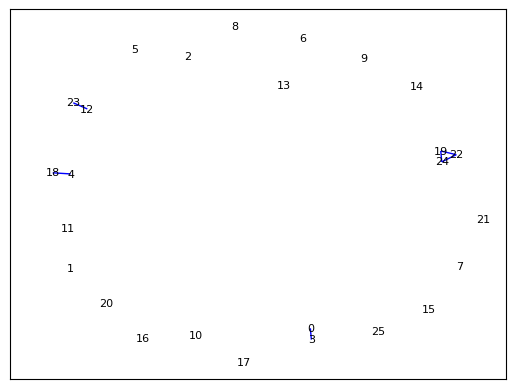

In [61]:
import torch
# from torch import tensor
import torch_geometric as pyg
from torch_geometric.data import Data
import networkx as nx
from torch_geometric.utils import k_hop_subgraph, remove_self_loops, to_networkx

a = torch.tensor([False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True]).view(-1,1)
b=torch.unique(torch.nonzero(a)[:,0])
# print(b)  #tensor([12, 23, 25])
idx_update = b
module_asy_graph_edge_index = torch.tensor([[ 3,  0, 18, 23,  4, 22, 24, 19, 24, 12, 19, 22],
                                            [ 0,  3,  4, 12, 18, 19, 19, 22, 22, 23, 24, 24]])
pos  = torch.tensor([[5.4000e+01, 5.2000e+01, 0.0000e+00],
        [5.7000e+01, 4.0000e+00, 7.0000e-10],
        [5.3000e+01, 3.3000e+01, 7.0500e-10],
        [5.4000e+01, 5.1000e+01, 7.4500e-10],
        [5.8000e+01, 9.0000e+00, 9.1000e-10],
        [5.7000e+01, 2.3000e+01, 9.2500e-10],
        [5.0000e+01, 4.7000e+01, 9.3000e-10],
        [4.9000e+01, 0.0000e+00, 9.5500e-10],
        [1.1000e+02, 5.4000e+01, 9.8000e-10],
        [5.1000e+01, 5.4000e+01, 9.8000e-10],
        [5.7000e+01, 1.7000e+01, 1.1150e-09],
        [4.9000e+01, 5.8000e+01, 1.1200e-09],
        [5.7000e+01, 1.3000e+01, 1.1250e-09],
        [5.3000e+01, 5.7000e+01, 1.1450e-09],
        [5.1000e+01, 4.0000e+01, 1.2400e-09],
        [5.0000e+01, 6.2000e+01, 1.2500e-09],
        [5.7000e+01, 2.0000e+01, 1.5850e-09],
        [5.5000e+01, 4.3000e+01, 1.5900e-09],
        [5.8000e+01, 1.0000e+01, 1.6000e-09],
        [1.0600e+02, 5.2000e+01, 1.6400e-09],
        [5.3000e+01, 6.1000e+01, 1.8250e-09],
        [1.0200e+02, 6.3000e+01, 1.8350e-09],
        [1.0500e+02, 5.3000e+01, 1.8900e-09],
        [5.8000e+01, 1.3000e+01, 2.3500e-09],
        [1.0600e+02, 5.2000e+01, 2.3850e-09],
        [5.6000e+01, 1.4000e+01, 2.4000e-09]])
data = Data(x=torch.zeros(26),edge_index=module_asy_graph_edge_index, pos=pos[:,:2])
pos_list = pos[:,:2].tolist()

g = to_networkx(data, to_undirected=True)
print(g.edges)
nx.draw_networkx(g, with_labels=True,  node_size=0, node_shape='.',  font_size=8, font_color='k',  edge_color='b', width=1)
# nx.draw_networkx_edges(g, pos = pos_list)


Global seed set to 12345


sync, graph:
after conv1:
tensor([[0.0754, 0.0169],
        [0.1102, 0.0223],
        [0.0604, 0.0101],
        [0.0797, 0.0150],
        [0.1059, 0.0210],
        [0.1442, 0.0366],
        [0.0834, 0.0146],
        [0.1061, 0.0217]], grad_fn=<DivBackward0>)

sync graph.num_nodes = 8
graph:


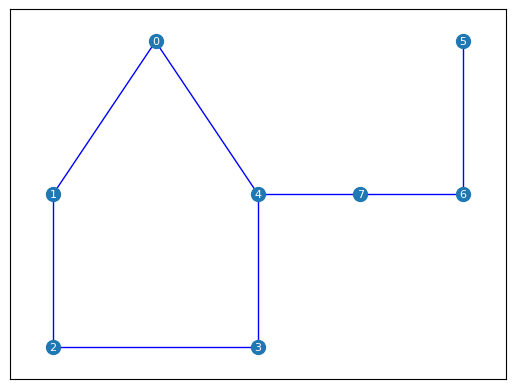

In [2]:
import torch
import aegnn
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SplineConv, BatchNorm
from torch.nn.functional import elu
import pytorch_lightning as pl
import networkx as nx
from torch_geometric.utils import to_networkx

pl.seed_everything(12345)
device = torch.device('cpu')

# def network
class net(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = SplineConv(1, 2, dim=2, kernel_size=2, bias=False, root_weight=False)
        self.conv2 = SplineConv(2, 4, dim=2, kernel_size=2, bias=False, root_weight=False)
        # self.conv1 = GCNConv(1, 2)
        # self.conv2 = GCNConv(2, 4)
        self.norm1 = BatchNorm(in_channels=2)
        self.norm2 = BatchNorm(in_channels=4)
        self.act = elu

    def forward(self, data):
        data.x = self.conv1(data.x, data.edge_index, data.edge_attr)
        print(f'after conv1:\n{data.x}\n')

        # data.x = self.act(data.x)
        # print(f'after elu1:\n{data.x}\n')

        # data.x = self.conv2(data.x, data.edge_index, data.edge_attr)
        # print(f'after conv2:\n{data.x}\n')

        return data.x

module = net()
module.eval()
# print(module.norm1.training)

# def graph for sync
attr_func = torch_geometric.transforms.Cartesian(cat=False, max_value=10.0)
graph = Data(
    x = torch.tensor([1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], device=device).view(-1,1),
    pos = torch.tensor([[2,3],[1,2],[1,1],[3,1],[3,2],[5,3],[5,2],[4,2]], device=device),
    # edge_index = torch.tensor([[0,1,1,2,2,3,3,4,4,0,4,7,7,6,6,5], 
    #                            [1,0,2,1,3,2,4,3,0,4,7,4,6,7,5,6]], device=device, dtype=torch.long))
    edge_index = torch.tensor([[0,1,1,2,2,3,3,4,4,0,5,6,4,6,7,7], 
                               [1,0,2,1,3,2,4,3,0,4,6,5,7,7,4,6]], device=device, dtype=torch.long))
graph = attr_func(graph)
print('sync, graph:')
output = module.forward(graph)
print(f'sync graph.num_nodes = {graph.num_nodes}')
print('graph:')
g_nx = to_networkx(graph, to_undirected=True)
nx.draw_networkx(g_nx, with_labels=True, pos=graph.pos.tolist(), node_size=100, node_shape='o',  font_size=8, font_color='w',  edge_color='b', width=1)


# def graph_init, node_x for AEGNN
x = torch.tensor([1.0, 0.0, 1.0, 1.0, 1.0], device=device).view(-1,1)
edge_index = torch.tensor([[0,1,1,2,2,3,3,4,4,0],
                           [1,0,2,1,3,2,4,3,0,4]], device=device, dtype=torch.long)
pos = torch.tensor([[2,3],[1,2],[1,1],[3,1],[3,2]], device=device)

graph_init = Data(x=x, pos=pos, edge_index=edge_index)
graph_init = attr_func(graph_init)

node_1 = Data(x=torch.tensor([[1.0]], device=device), pos=torch.tensor([[5,3]], device=device))
node_2 = Data(x=torch.tensor([[1.0]], device=device), pos=torch.tensor([[5,2]], device=device))
node_3 = Data(x=torch.tensor([[1.0]], device=device), pos=torch.tensor([[4,2]], device=device))


False
async, init:
after conv1:
tensor([[0.0754, 0.0169],
        [0.1102, 0.0223],
        [0.0604, 0.0101],
        [0.0797, 0.0150],
        [0.1021, 0.0210]], grad_fn=<DivBackward0>)

async, add node 1:
after conv1:
tensor([[0.0754, 0.0169],
        [0.1102, 0.0223],
        [0.0604, 0.0101],
        [0.0797, 0.0150],
        [0.1021, 0.0210],
        [0.0000, 0.0000]], grad_fn=<CatBackward0>)

async, add node 2:
after conv1:
tensor([[0.0754, 0.0169],
        [0.1102, 0.0223],
        [0.0604, 0.0101],
        [0.0797, 0.0150],
        [0.1021, 0.0210],
        [0.1442, 0.0366],
        [0.0000, 0.0000]], grad_fn=<IndexPutBackward0>)

async, add node 3:
after conv1:
tensor([[0.0754, 0.0169],
        [0.1102, 0.0223],
        [0.0604, 0.0101],
        [0.0797, 0.0150],
        [0.1059, 0.0210],
        [0.1442, 0.0366],
        [0.0834, 0.0146],
        [0.0000, 0.0000]], grad_fn=<IndexPutBackward0>)

async edge: 
tensor([[0, 1, 1, 2, 2, 3, 3, 4, 4, 0, 5, 6, 4, 6, 7, 7],
        [1,

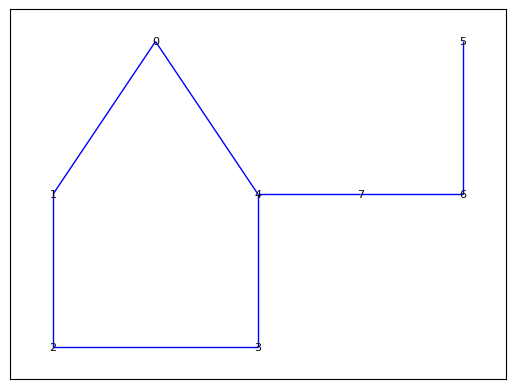

In [42]:
# async model
module = aegnn.asyncronous.make_model_asynchronous(module, 1.0, (10,10), attr_func)
module.eval()
print(module.norm1.training)
module = aegnn.asyncronous.reset_async_module(module)
aegnn.asyncronous.register_sync_graph(module, graph)
print('async, init:')
module.forward(graph_init)
print('async, add node 1:')
module.forward(node_1)
print('async, add node 2:')
module.forward(node_2)
print('async, add node 3:')
module.forward(node_3)


asy_graph = module.conv1.asy_graph
print(f'async edge: \n{asy_graph.edge_index}')
print(f'conv2.asy_graph.num_nodes: \n{asy_graph.num_nodes}')
print('graph:')
asy_graph_nx = to_networkx(asy_graph, to_undirected=True)
nx.draw_networkx(asy_graph_nx, with_labels=True, pos=asy_graph.pos.tolist(), node_size=0, node_shape='.',  font_size=8, font_color='k',  edge_color='b', width=1)


causal:
edge_index:
tensor([[0, 0, 0, 1, 1, 1, 2, 3, 4, 5],
        [1, 2, 3, 0, 4, 5, 0, 0, 1, 1]])
degree:
tensor([3., 3., 1., 1., 1., 1.])

torch_geometric:
edge_index:
tensor([[1, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1, 2, 0, 1, 2, 3, 0, 1, 2, 3],
        [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5]])
degree:
tensor([3., 3., 3., 3., 4., 4.])


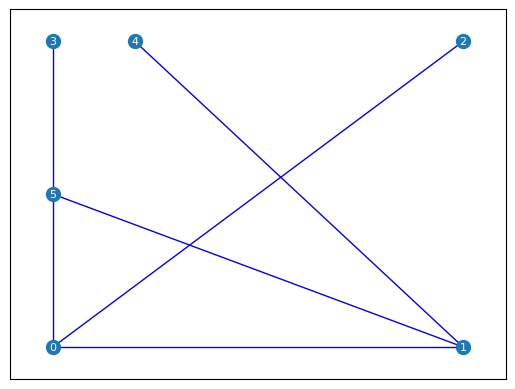

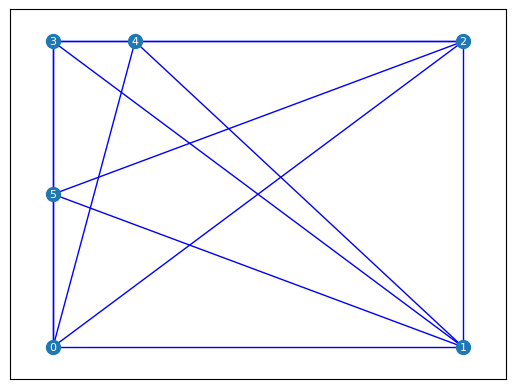

In [69]:
import torch
import torch_geometric
import aegnn
from torch import Tensor, tensor
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected, degree

def printg(graph):
    import networkx as nx
    from torch_geometric.utils import to_networkx
    import matplotlib.pyplot as plt
    import numpy as np

    fig, ax = plt.subplots()
    g_nx = to_networkx(graph, to_undirected=True)
    pos = dict(zip(np.arange(graph.num_nodes),graph.pos.tolist()))
    nx.draw_networkx(g_nx, pos=pos, with_labels=True, ax=ax, node_size=100, node_shape='o',  font_size=8, font_color='w',  edge_color='b', width=1)

def pos_dist(pos):
    num_nodes = pos.shape[0]
    node_distance = []
    for i in range(num_nodes):
        d = (pos-pos[i, :]).pow(2).sum(1).sqrt().view(1,-1)
        node_distance.append(d)
    node_distances = torch.cat(node_distance, dim=0)
    return node_distances

def causal_radius_graph(data_pos: Tensor, r: float, max_num_neighbors: int = 4, reserve_future_edges: bool = True):
    pos = data_pos.clone().detach()
    pos = pos.to('cpu')
    num_nodes = pos.shape[0]

    # allowed edges to connect older nodes; reserve some edges for future nodes
    if reserve_future_edges:
        num_old_edges = max_num_neighbors // 2 
    else:
        num_old_edges = max_num_neighbors

    # set neighbors counter
    available_neighbors = max_num_neighbors * torch.ones(num_nodes)

    # calculate collection distance
    # dist_table = torch.cdist(pos, pos, p=2) # for PyTorch >= 1.13.0
    dist_table = pos_dist(pos)
    connection_mask = dist_table <= r

    edges_new_list = []
    for i in range(num_nodes):
        # check available neighbors
        full_neighbors_idx = (available_neighbors <= 0).nonzero()
        connection_mask[full_neighbors_idx, :] = False # if full, hidden this node

        # connection mask for the i-th node
        node_connection_mask = connection_mask[:i, i]  # ":i" can remove self-loop

        # create connected nodes idx
        idx_src = torch.nonzero(node_connection_mask).to(torch.long)
        if idx_src.numel() > num_old_edges:
            idx_src = idx_src[:num_old_edges] # clamp, reserve some edges for future nodes; for now, first connect older nodes, not nearer nodes
        idx_dst = (i * torch.ones_like(idx_src)).to(torch.long)

        # when connected, -1 available neighbors for every 2 nodes of an edge
        available_neighbors[idx_src] -= 1
        available_neighbors[idx_dst] -= idx_dst.numel()

        # create edges
        edge_new = torch.cat([idx_src, idx_dst], dim=1).T
        edges_new_list.append(edge_new)

    edges_new = torch.cat(edges_new_list, dim=1)
    edges_new = to_undirected(edges_new)

    edge_index = edges_new.detach().clone()

    return edge_index

    


device = 'cpu'
pos = torch.tensor([[0,0],[1,0],[1,1],[0,1],[0.2,1],[0,0.5]], device=device, dtype=torch.float)
r = 1.5
max_num_neighbors = 3

causal_edge_index = causal_radius_graph(pos, r, max_num_neighbors=max_num_neighbors, reserve_future_edges=True)
pyg_edge_index = torch_geometric.nn.pool.radius_graph(pos, r, max_num_neighbors=max_num_neighbors)

print(f'\ncausal:')
print(f'edge_index:\n{causal_edge_index}')
print(f'degree:\n{degree(causal_edge_index[1,:])}')
print(f'\ntorch_geometric:')
print(f'edge_index:\n{pyg_edge_index}')
print(f'degree:\n{degree(pyg_edge_index[1,:])}')


printg(Data(pos=pos, edge_index=causal_edge_index))
printg(Data(pos=pos, edge_index=pyg_edge_index))


In [62]:
import torch

a = torch.tensor([[1,2,3]])
b = torch.tensor([[1,3,4]])

diff_idx = (torch.nonzero(a - b).T)[1,:]

print(diff_idx)
print(b[:, diff_idx])

c=2*torch.ones(1,4)
d = torch.ones(4,4)
print(c)
print(d)
e = torch.mul(c,d)
f = torch.matmul(c,d)
print(e)
print(f)

tensor([[-7.1328,  7.5697]], device='cuda:0')
tensor([[ 8.6325e-05, -6.8978e-06]], device='cuda:0')

w = 
tensor([[[ 0.3480, -0.0275, -0.2947, -0.2274, -0.0937,  0.0478, -0.1148,
          -0.2037]],

        [[-0.0287,  0.2230,  0.2940, -0.1746, -0.2027, -0.0163,  0.1556,
           0.1583]],

        [[-0.1316,  0.1225, -0.0601, -0.0424, -0.2867,  0.2533, -0.2493,
           0.0881]],

        [[-0.1769, -0.2981, -0.0225,  0.1173, -0.3244,  0.0256, -0.1329,
          -0.0504]],

        [[-0.1577, -0.0440,  0.3180, -0.3399, -0.1673,  0.3005, -0.0186,
          -0.0735]],

        [[ 0.1189, -0.1493,  0.1452, -0.2181, -0.1063,  0.2706,  0.0347,
          -0.2796]],

        [[ 0.2124, -0.2350, -0.0228, -0.0010, -0.1558,  0.1582, -0.0350,
           0.1931]],

        [[ 0.1796, -0.2765,  0.2640,  0.0088,  0.2792,  0.2200, -0.1040,
          -0.0700]]], device='cuda:0', requires_grad=True)

ws = 
tensor([[[-0.0840, -0.2205,  0.0673,  0.2248,  0.3259, -0.1576, -0.2526,
          -0.0138]],

        [[ 0.1008,  0.1423, -0.1449,  0.0797, -0.0985, -0.1157, -0.3165,
           0.1728]],

        [[-0.2464,  0.1189, -0.0686, -0.3398, -0.0347,  0.0643, -0.2325,
           0.0955]],

        [[-0.2176, -0.0493, -0.2218, -0.0682,  0.4710, -0.4216, -0.1511,
           0.3409]],

        [[ 0.0122, -0.0902,  0.2149, -0.1475,  0.1771, -0.2012, -0.1562,
           0.2731]],

        [[-0.0202, -0.2956,  0.1991, -0.2777, -0.0612, -0.0743, -0.1856,
           0.0777]],

        [[-0.0320,  0.2238,  0.2880, -0.3183,  0.2519, -0.0442,  0.3710,
           0.2899]],

        [[-0.1886, -0.0689, -0.1935, -0.1915,  0.4268,  0.2480,  0.1727,
           0.3580]]], device='cuda:0', requires_grad=True)

tensor([ 0.1186,  0.0603, -0.1125,  0.3718, -0.2075,  0.3228, -0.0940, -0.0887],
device='cuda:0')

tensor([0.9722, 0.9820, 0.9908, 0.9776, 1.0522, 0.9644, 1.0242, 1.0270],
       device='cuda:0', requires_grad=True)


sync_sudo_result = 0.4749999940395355

tensor([1, 2])
tensor([[3, 4]])
tensor([[2., 2., 2., 2.]])
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor([[2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.]])
tensor([[8., 8., 8., 8.]])


In [2]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

import torch
import torch_geometric
import aegnn
from torch_geometric.data import Data


device = torch.device('cpu')
tot_nodes = 3000
x_n = torch.round(torch.rand(tot_nodes+1, device=device), decimals=0).view(-1,1)
pos_n = torch.rand(tot_nodes+1,3)*98.0
pos_n[:,:2] = torch.round(pos_n[:,:2])
pos_n[:,2] *= 1e-10
pos_n = pos_n[torch.argsort(pos_n[:,2]).squeeze(),:]
pos_n = pos_n.to(device)
random_sample = Data(x = x_n[:tot_nodes,:],pos = pos_n[:tot_nodes,:])
from aegnn.asyncronous.base.utils import causal_radius_graph
print('Generating random graph...')
random_sample.edge_index = causal_radius_graph(random_sample.pos, r=3.0, max_num_neighbors=32).to(device)
print('Done')


/users/yyang22/anaconda3/envs/aegnn/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generating random graph...
Done


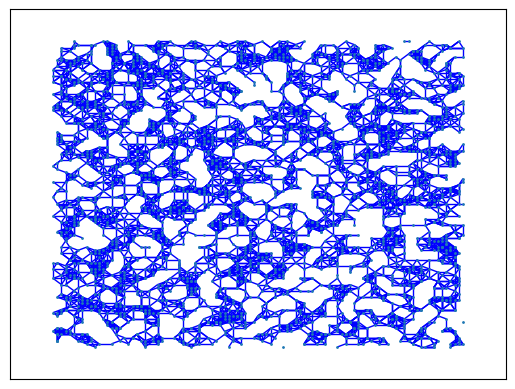

In [3]:
def printg(graph):
    import networkx as nx
    from torch_geometric.utils import to_networkx
    import matplotlib.pyplot as plt
    import numpy as np

    fig, ax = plt.subplots()
    graph.pos = graph.pos[:,:2]
    g_nx = to_networkx(graph, to_undirected=True)
    pos = dict(zip(np.arange(graph.num_nodes),graph.pos.tolist()))
    nx.draw_networkx(g_nx, pos=pos, with_labels=False, ax=ax, node_size=1, node_shape='o',  font_size=8, font_color='w',  edge_color='b', width=1)
    # nx.draw_networkx(g_nx, with_labels=False, ax=ax, node_size=1, node_shape='o',  font_size=8, font_color='w',  edge_color='b', width=1)

printg(random_sample)

Generating random graph...
Done
Data(x=[3250, 1], pos=[3250, 3], file_id='sequence_1', label=[1], y=[1], edge_index=[2, 64306])


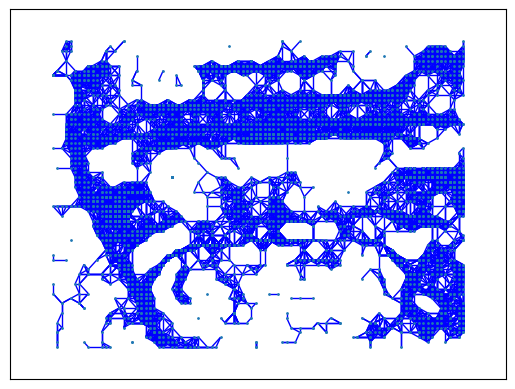

In [10]:
path = "/space/yyang22/datasets/data/storage/ncars/processed/training/sequence_1"
ncars_sample = torch.load(path)
ncars_sample.x   =   ncars_sample.x[1000*0:1000*6,:]
ncars_sample.pos = ncars_sample.pos[1000*0:1000*6,:]
from aegnn.asyncronous.base.utils import causal_radius_graph
print('Generating random graph...')
ncars_sample.edge_index = causal_radius_graph(ncars_sample.pos, r=3.0, max_num_neighbors=32).to(device)
print('Done')
print(ncars_sample)
printg(ncars_sample)

Data(x=[6000, 1], pos=[6000, 3])
Generating graph...
Done


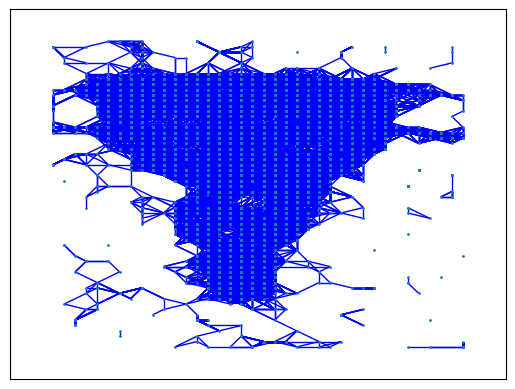

In [11]:
import numpy as np
def load_ncal_data(raw_file: str):
    f = open(raw_file, 'rb')
    raw_data = np.fromfile(f, dtype=np.uint8)
    f.close()

    raw_data = np.uint32(raw_data)
    all_y = raw_data[1::5] //3
    all_x = raw_data[0::5] //3
    all_p = (raw_data[2::5] & 128) >> 7  # bit 7
    all_ts = ((raw_data[2::5] & 127) << 16) | (raw_data[3::5] << 8) | (raw_data[4::5])
    all_ts = all_ts / 1e6  # µs -> s
    all_p = all_p.astype(np.float32)
    # all_p[all_p == 0] = -1
    events = np.column_stack((all_x, all_y, all_ts, all_p)).astype(np.float32)
    events = torch.from_numpy(events[:6000, :])
    events_data = torch_geometric.data.Data(x=events[:, 3].view(-1,1), pos=events[:,:3])
    return events_data

path = "/space/yyang22/datasets/data/storage/ncaltech101/training/buddha/image_0039.bin"
events_graph = load_ncal_data(path)
print(events_graph)
from aegnn.asyncronous.base.utils import causal_radius_graph
print('Generating graph...')
events_graph.edge_index = causal_radius_graph(events_graph.pos, r=3.0, max_num_neighbors=32).to(device)
print('Done')
printg(events_graph)
torch.save(events_graph, "/space/yyang22/datasets/data/storage/ncars/processed/test_sample")

In [19]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

import torch
import torch_geometric
import aegnn
from torch_geometric.data import Data
import numpy as np
from tqdm.auto import tqdm, trange
from glob import glob

device = torch.device('cpu')
def load_ncal_data(raw_file: str):
    f = open(raw_file, 'rb')
    raw_data = np.fromfile(f, dtype=np.uint8)
    f.close()

    raw_data = np.uint32(raw_data)
    all_y = raw_data[1::5]
    all_x = raw_data[0::5]
    all_p = (raw_data[2::5] & 128) >> 7  # bit 7
    all_ts = ((raw_data[2::5] & 127) << 16) | (raw_data[3::5] << 8) | (raw_data[4::5])
    all_ts = all_ts / 1e6  # µs -> s
    all_p = all_p.astype(np.float64)
    # all_p[all_p == 0] = -1
    events = np.column_stack((all_x, all_y, all_ts, all_p))
    events = torch.from_numpy(events)
    events_data = torch_geometric.data.Data(x=events[:, 3].view(-1,1), pos=events[:,:3])
    return events_data


dir = "/space/yyang22/datasets/data/storage/ncaltech101/training/airplanes/"
files = glob(dir+"*.bin")
ncal_samples = []
for file in files:
    ncal_samples.append(load_ncal_data(file))

num_nodes = []
xs = []
ys = []
ts = []
for ncal_sample in (tqdm(ncal_samples)):
    num_nodes.append(ncal_sample.num_nodes)
    x = [ncal_sample.pos[:,0].min().item(), ncal_sample.pos[:,0].max().item()]
    y = [ncal_sample.pos[:,1].min().item(), ncal_sample.pos[:,1].max().item()]
    t = [ncal_sample.pos[:,2].min().item(), ncal_sample.pos[:,2].max().item()]
    xs.append(x)
    ys.append(y)
    ts.append(t)
max_num_nodes = np.array(num_nodes).max()
min_num_nodes = np.array(num_nodes).min()
xs_np = np.array(xs)
ys_np = np.array(ys)
ts_np = np.array(ts)
print(min_num_nodes)
print(max_num_nodes)
print(xs_np.max(axis=0))
print(ys_np.max(axis=0))
print(ts_np.max(axis=0))

100%|██████████| 800/800 [02:00<00:00,  6.63it/s]

159194
[  0. 232.]
[  0. 172.]
[0.000395 0.309817]


In [20]:
min_num_nodes = np.array(num_nodes).min()
print(min_num_nodes)

22288


In [21]:
dir = "/space/yyang22/datasets/data/storage/ncars/processed/validation/"
files = glob(dir+"*")
ncars_samples = []
for file in files:
    ncars_samples.append(torch.load(file))

num_nodes = []
for ncars_sample in (tqdm(ncars_samples)):
    num_nodes.append(ncars_sample.num_nodes)
max_num_nodes = np.array(num_nodes).max()
min_num_nodes = np.array(num_nodes).min()
avg_num_nodes = np.array(num_nodes).mean()
print(max_num_nodes)
print(min_num_nodes)
print(avg_num_nodes)

100%|██████████| 2462/2462 [00:00<00:00, 199836.99it/s]

40810
500
3919.241267262388


In [10]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

import functools
import glob
import logging
import numpy as np
import os
import torch


from torch_geometric.data import Data
from torch_geometric.nn.pool import radius_graph
from torch_geometric.transforms import FixedPoints
from tqdm import tqdm
from typing import Callable, Dict, List, Optional, Union

from aegnn.utils.multiprocessing import TaskManager

def read_label(raw_file: str) -> Optional[Union[str, List[str]]]:
    return raw_file.split("/")[-2]

classes =  os.listdir('/space/yyang22/datasets/data/storage/ncaltech101/annotations/')
label_dict = {lbl: i for i, lbl in enumerate(classes)}
# print(label_dict)

annotation_file = "/space/yyang22/datasets/data/storage/ncaltech101/annotations/buddha/annotation_0001.bin"
raw_file = "/space/yyang22/datasets/data/storage/ncaltech101/training/buddha/image_0001.bin"
f = open(annotation_file)
annotations = np.fromfile(f, dtype=np.int16)
print(annotations)
annotations = np.array(annotations[2:10])
f.close()

label = read_label(raw_file)
# class_id = map_label(label, classes)
class_id = label_dict.get(label, None)
print(label, class_id)

# Create bounding box from corner, shape and label variables. NCaltech101 bounding boxes
# often start outside of the frame (negative corner coordinates). However, the shape turns
# out to be the shape of the bbox starting at the image's frame.
bbox = np.array([
    annotations[0], annotations[1],  # upper-left corner
    annotations[2] - annotations[0],  # width
    annotations[5] - annotations[1],  # height
    class_id
])
print(bbox)
bbox[:2] = np.maximum(bbox[:2], 0)
print(bbox)

[  2   5  -4  31  91  31  91 149  -4 149  -4  31   2  34  49  74  67  80
  81 120  73 129  90 138  91 146  91 149  80 149  49 148  42 147  28 149
   9 149   5 147  -1 149  -4 148  -4 125  -1 124   1 116   2 106   4  81
  11  75  25  71  23  57  22  51  24  47  29  37  34  31  41  31  45  37
  49  42  52  51  50  66  49  74  49  74]
buddha 54
[ -4  31  95 118  54]
[  0  31  95 118  54]


In [15]:
import torch

idx = torch.tensor([3,1])
a = torch.randn(4,3)
b = torch.randn(4,3)
print(a)
print(b)
a[idx,:] = torch.max(a[idx,:],b[idx,:])
print(a)

tensor([[ 1.3280, -0.2410,  1.3612],
        [-0.4924,  0.2129, -0.0349],
        [ 1.0410,  0.8611,  0.5605],
        [-0.1597, -1.5269, -0.2655]])
tensor([[-1.0840, -0.1730, -0.1253],
        [-0.6536, -0.9617,  0.0566],
        [-0.1986,  1.9529, -0.1743],
        [-0.1040,  0.4864,  1.6679]])
tensor([[ 1.3280, -0.2410,  1.3612],
        [-0.4924,  0.2129,  0.0566],
        [ 1.0410,  0.8611,  0.5605],
        [-0.1040,  0.4864,  1.6679]])


In [46]:
import torch

channels = 2
size = 4
cluster = torch.tensor([1,2,1], dtype=torch.long)
x = torch.tensor([[1,8,3],[4,5,6],[7,2,9]])
x_group = [torch.tensor([]) for i in range(size)]
print(x_group[0])

for i in range(x.shape[0]):
    x_group[cluster[i]] = torch.cat([x_group[cluster[i]], x[i,:].view(1,-1)])
print(x_group)

m,_ = torch.max(x_group[1], dim=0)
print(m)

t1 = torch.tensor([1,2,3,4]).view(-1,1)
print(t1)
ti = torch.tensor([1,3])
t2 = torch.tensor([8,9]).view(-1,1)
print(t2)
t1[ti] = t2
print(t1)

tensor([])
[tensor([]), tensor([[1., 8., 3.],
        [7., 2., 9.]]), tensor([[4., 5., 6.]]), tensor([])]
tensor([7., 8., 9.])
tensor([[1],
        [2],
        [3],
        [4]])
tensor([[8],
        [9]])
tensor([[1],
        [8],
        [3],
        [9]])


In [18]:
import torch

cluster = torch.tensor([3,1,3])
idx_group = [[] for i in range(5)]

x = torch.arange(16).view(4,4)
print(x)

idx_group = [torch.tensor([], dtype=torch.long) for i in range(4)]
for i, c in enumerate(cluster):
    idx_group[c] = torch.cat([idx_group[c], torch.tensor([i], dtype=torch.long)])

print(idx_group)
grid_changed = torch.tensor([1,3])
for g in grid_changed:
    idx_selected = idx_group[g]
    print(idx_selected)
    print(x[idx_selected,:])


tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])
[tensor([], dtype=torch.int64), tensor([1]), tensor([], dtype=torch.int64), tensor([0, 2])]
tensor([1])
tensor([[4, 5, 6, 7]])
tensor([0, 2])
tensor([[ 0,  1,  2,  3],
        [ 8,  9, 10, 11]])


In [66]:
import torch
from torch import tensor

a = tensor([1,1,2,2,3,3,4,4], dtype=torch.float).view(-1,2)
print(a)
b = tensor([[7,7]], dtype=torch.float)
idx = tensor([3])
a[idx,:] = b
print(a)

tensor([[1., 1.],
        [2., 2.],
        [3., 3.],
        [4., 4.]])
tensor([[1., 1.],
        [2., 2.],
        [3., 3.],
        [7., 7.]])


In [138]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

import functools
import glob
import logging
import numpy as np
import os
import torch


from torch_geometric.data import Data
from torch_geometric.nn.pool import radius_graph
from torch_geometric.transforms import FixedPoints
from tqdm import tqdm
from typing import Callable, Dict, List, Optional, Union

from typing import Callable, Optional, Union

import torch
from torch import Tensor
from torch.nn import Linear

# from torch_geometric.nn.conv import PointNetConv
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import reset
from torch_geometric.typing import (
    Adj,
    OptTensor,
    PairOptTensor,
    PairTensor
)
from torch_geometric.utils import add_self_loops, remove_self_loops
from torch_geometric.nn.norm import BatchNorm
import pytorch_lightning as pl

torch.set_printoptions(precision=8)
# pl.seed_everything(12345)

bn = BatchNorm(4)
bn.training = False
bn.module.training = False
# bn.module.running_mean = torch.tensor([0.1,0.2,0.3,0.4])
# bn.module.running_var = torch.tensor([0.2,0.3,0.4,0.5])
# bn.module.weight = torch.nn.Parameter(torch.tensor([0.4,0.3,0.2,0.1]))
# bn.module.bias = torch.nn.Parameter(torch.tensor([0.5,0.4,0.3,0.2]))
bn.module.running_mean = torch.randn(4)*10
bn.module.running_var = torch.rand(4)*9
bn.module.weight = torch.nn.Parameter(torch.rand(4)*3)
bn.module.bias = torch.nn.Parameter(torch.randn(4)*2)
print(f'mean=\n{bn.module.running_mean}')
print(f'var=\n{bn.module.running_var}')
print(f'weight=\n{bn.module.weight}')
print(f'bias=\n{bn.module.bias}')

ti = torch.rand(2,4)
to = bn.forward(ti)

w = bn.module.weight / torch.sqrt(bn.module.running_var + bn.module.eps)
b = bn.module.bias - w * bn.module.running_mean
print(w)
print(ti)
print(to)
print(w*ti+b)

mean=
tensor([ -4.35706425, -12.47449303, -10.21949577,   9.92958260])
var=
tensor([7.08824921, 5.41800547, 5.61166096, 7.33555412])
weight=
Parameter containing:
tensor([1.19970167, 2.36823702, 1.05766606, 0.87788433], requires_grad=True)
bias=
Parameter containing:
tensor([-3.97522473, -3.53272128, -1.17362511, -3.05986857],
       requires_grad=True)
tensor([0.45061272, 1.01743126, 0.44648048, 0.32413098],
       grad_fn=<DivBackward0>)
tensor([[0.09808111, 0.73075223, 0.78334832, 0.84899491],
        [0.22013390, 0.04653537, 0.41476637, 0.31087720]])
tensor([[-1.96767950,  9.90270615,  3.73892999, -6.00316858],
        [-1.91268098,  9.20656204,  3.57436538, -6.17758942]],
       grad_fn=<NativeBatchNormBackward0>)
tensor([[-1.96767950,  9.90270805,  3.73892999, -6.00316811],
        [-1.91268098,  9.20656395,  3.57436538, -6.17758894]],
       grad_fn=<AddBackward0>)


In [139]:
class MyConv(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int, bias: bool = False, pos_dim: int = 3, add_self_loops: bool = False, **kwargs):
        kwargs.setdefault('aggr', 'max')
        super().__init__(**kwargs)

        self.local_nn = Linear(in_channels+pos_dim, out_channels, bias=bias)
        self.global_nn = None
        self.add_self_loops = add_self_loops

        self.reset_parameters()

    def reset_parameters(self):
        reset(self.local_nn)
        reset(self.global_nn)


    def forward(self, x: Union[OptTensor, PairOptTensor],
                pos: Union[Tensor, PairTensor], edge_index: Adj) -> Tensor:
        
        out = self.propagate(edge_index, x=x, pos=pos, size=None)

        return out


    def message(self, x_j: Optional[Tensor], pos_i: Tensor,
                pos_j: Tensor) -> Tensor:
        msg = pos_j - pos_i
        msg = torch.cat([x_j, msg], dim=1)
        msg = self.local_nn(msg)
        print(f'msg:\n{msg}\n')
        return msg

In [140]:
my1 = MyConv(2,4)
print(my1.local_nn.weight)
g = Data(x=torch.rand(3,2), pos=torch.rand(3,3), edge_index=torch.tensor([[0,1,0,2],[1,0,2,0]], dtype=torch.long))
g1 = my1.forward(x=g.x, pos=g.pos, edge_index=g.edge_index)
print(f'x=\n{g.x}')
print(f'pos=\n{g.pos}')
print(f'after conv:\n{g1}')
g2 = bn.forward(g1)
g2_prime = g1*w+b
same = torch.allclose(g2,g2_prime, atol=1e-5)
print(f'after bn:\n{g2}')
print(f'after *w+b:\n{g2_prime}')
print(f'same?{same}')

Parameter containing:
tensor([[-0.13078994,  0.35109842, -0.03901826, -0.22888085, -0.24229889],
        [-0.13802539,  0.07617034, -0.02553411,  0.17189734, -0.30252802],
        [-0.22425714, -0.22069186,  0.43416676,  0.26570368,  0.26722866],
        [-0.12562981, -0.15586588, -0.15978587,  0.10642395,  0.38279828]],
       requires_grad=True)
msg:
tensor([[ 0.25202560, -0.03392239, -0.73669386, -0.22081956],
        [ 0.05718205, -0.10799331, -0.04180577, -0.26657337],
        [ 0.07107851,  0.18674734, -0.38713798, -0.25712633],
        [ 0.35938415, -0.22554582, -0.25289613, -0.15541841]],
       grad_fn=<MmBackward0>)

x=
tensor([[0.96482903, 0.82575917],
        [0.94120473, 0.76495630],
        [0.24069738, 0.84936476]])
pos=
tensor([[0.19476795, 0.83919734, 0.31332010],
        [0.80575156, 0.96969569, 0.45605582],
        [0.45478487, 0.01167536, 0.67074734]])
after conv:
tensor([[ 0.35938415, -0.10799331, -0.04180577, -0.15541841],
        [ 0.25202560, -0.03392239, -0.736

In [141]:

my1.local_nn.weight = torch.nn.Parameter(my1.local_nn.weight * w.view(-1,1))
print(f'weight=\n{my1.local_nn.weight}')
my1.local_nn.bias = torch.nn.Parameter(b)

out = my1.propagate(g.edge_index, x=g.x, pos=g.pos, size=None)
print(f'fuse=\n{out}')
print(f'*w+b=\n{g1*w + b}')
same2 = torch.allclose(out, g2, atol=1e-5)
print(f'same?{same2}')

weight=
Parameter containing:
tensor([[-0.05893561,  0.15820941, -0.01758213, -0.10313662, -0.10918296],
        [-0.14043134,  0.07749809, -0.02597920,  0.17489372, -0.30780146],
        [-0.10012644, -0.09853461,  0.19384699,  0.11863150,  0.11931238],
        [-0.04072051, -0.05052096, -0.05179155,  0.03449530,  0.12407678]],
       requires_grad=True)
msg:
tensor([[-1.89831018,  9.12470436,  3.06026077, -6.34992838],
        [-1.98610914,  9.04934216,  3.37051463, -6.36475849],
        [-1.97984719,  9.34922028,  3.21633053, -6.36169624],
        [-1.84993303,  8.92974091,  3.27626705, -6.32872963]],
       grad_fn=<AddmmBackward0>)

fuse=
tensor([[-1.84993303,  9.04934216,  3.37051463, -6.32872963],
        [-1.89831018,  9.12470436,  3.06026077, -6.34992838],
        [-1.97984719,  9.34922028,  3.21633053, -6.36169624]],
       grad_fn=<CppNode<ScatterMax>>)
*w+b=
tensor([[-1.84993303,  9.04934216,  3.37051463, -6.32872963],
        [-1.89831018,  9.12470436,  3.06026077, -6.3499

In [142]:
print(isinstance(my1, MessagePassing))

True


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


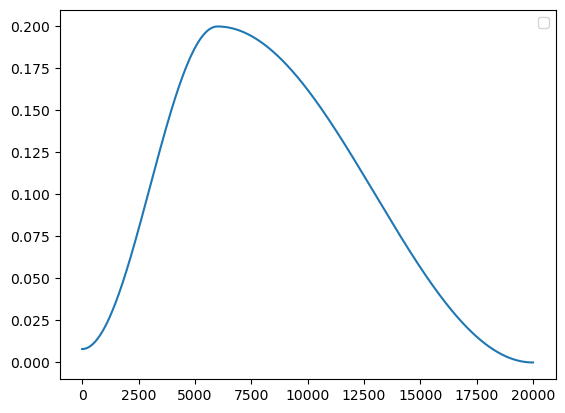

In [6]:
import torch
from torchvision.models import AlexNet
import matplotlib.pyplot as plt

steps = []
lrs = []
model = AlexNet(num_classes=2)
lr = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=lr*2, anneal_strategy='cos', epochs=100, steps_per_epoch=200)
for epoch in range(100):
    for batch in range(200):
        scheduler.step()
        lrs.append(scheduler.get_last_lr()[0])
        steps.append(epoch * 200 + batch)

plt.figure()
plt.legend()
plt.plot(steps, lrs, label='OneCycle')
plt.show()

In [39]:
import torch
from torch.quantization.observer import PerChannelMinMaxObserver, MinMaxObserver
torch.set_printoptions(precision=4)

test = torch.randn(2,4)
test[:,2] *= 100
test[:,3] *= 1
obs = PerChannelMinMaxObserver(ch_axis=1, dtype=torch.qint8, qscheme=torch.per_channel_symmetric)
obs(test)
scale, zero_point = obs.calculate_qparams()
print(test)
print(scale)
print(zero_point)
# print(test/scale)
print(torch.round(test/scale)*scale)
print(f'min={obs.min_val}, max={obs.max_val}')
# print('')
# test2 = torch.randn(2,4)
# test2[:,2] *= 100
# test2[:,3] *= 1e-9
# obs(test2)
# scale, zero_point = obs.calculate_qparams()
# print(test2)
# print(scale)
# print(zero_point)
# print(f'min={obs.min_val}, max={obs.max_val}')
# print(test/scale)
# print(torch.round(test/scale)*scale)
# print(torch.round(test2/scale)*scale)

tensor([[ 3.2987e-02,  6.6696e-01, -7.6770e+01,  1.3124e+00],
        [ 3.7037e-01, -5.5381e-01, -3.2788e+01,  1.0406e+00]])
tensor([0.0029, 0.0052, 0.6021, 0.0103])
tensor([0, 0, 0, 0])
tensor([[ 3.1954e-02,  6.6958e-01, -7.7071e+01,  1.3073e+00],
        [ 3.7182e-01, -5.5449e-01, -3.2514e+01,  1.0397e+00]])
min=tensor([ 3.2987e-02, -5.5381e-01, -7.6770e+01,  1.0406e+00]), max=tensor([  0.3704,   0.6670, -32.7881,   1.3124])


In [1]:
import torch
from aegnn.asyncronous.base.utils import cdist, pos_dist

a = torch.round(torch.randn(3,2)*10)
print(a)
b = a[1,:]
print(b)
print(a-b)
c = cdist(a, b, p=1)
print(c)
d = pos_dist(a)
print(d)

/users/yyang22/anaconda3/envs/aegnn/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([[ 0., -2.],
        [ 3., -9.],
        [ 5., 19.]])
tensor([ 3., -9.])
tensor([[-3.,  7.],
        [ 0.,  0.],
        [ 2., 28.]])
tensor([[10.,  0., 30.]])
tensor([[ 0., 10., 26.],
        [10.,  0., 30.],
        [26., 30.,  0.]])


In [132]:
class Qtype():
    def __init__(self, dtype: str = None, *, bit: int = None, signed: bool = None) -> None:
        if dtype is not None:
            self.dtype = dtype
            self._bit, self._signed, self._format = Qtype.convert_dtype(self.dtype)
            self._min, self._max = self.get_range()
        elif bit is not None and signed is not None:
            self._bit = bit
            self._signed = signed
            self._format = 'int'
            self._min, self._max = self.get_range()
        else:
            raise ValueError(f'Init Error: Missing "dtype" or "bit with signed"')
        
    def __repr__(self) -> str:
        prefix = '' if self._signed else 'u'
        dtype_name = prefix + self._format + str(self._bit)
        return dtype_name

    @staticmethod
    def convert_dtype(dtype: str):
        dtype = dtype.lower()
        dtype = dtype.replace(' ','')
        signed = True
        bit = 32
        format = 'unkown'

        if 'int' in dtype:
            format = 'int'
            s = dtype.split('int')
            if s[0] == 'u' or s[0] == 'unsigned': signed = False
            if s[1] != '': bit = int(s[1])

        elif 'float' in dtype:
            format = 'float'
            s = dtype.split('float')
            if s[1] != '': bit = int(s[1])

        elif 'fp' in dtype:
            format = 'float'
            s = dtype.split('fp')
            if s[1] != '': bit = int(s[1])

        else:
            raise ValueError(f'Unkown data type: {dtype}')

        return bit, signed, format
    
    def get_range(self):
        if self._format == 'int':
            if self._signed:
                max = pow(2, self._bit-1) - 1
                min = - max  # symmetric clamp
            else:
                max = pow(2, self._bit) - 1
                min = 0
        elif self._format == 'float':
            max = float('+inf')
            min = float('-inf')
        else:
            raise ValueError(f'Unkown range')
        
        return min, max
    
    @property
    def bit(self):
        return self._bit
    
    @property
    def signed(self):
        return self._signed
    
    @property
    def format(self):
        return self._format
    
    @property
    def min(self):
        return self._min
    
    @property
    def max(self):
        return self._max


    

from typing import Union, Tuple
import torch
def quant_tensor(real, scale, dtype: Union[str, Qtype]):
    if isinstance(dtype, str):
        dtype = Qtype(dtype)

    quant = torch.round(real/scale)
    quant = torch.clamp(quant, min=dtype.min, max=dtype.max)

    return quant

class test_class():
    def __init__(self) -> None:
        pass

    def quant(self, f_dtype: Union[str, Qtype, Tuple[int, bool]], w_dtype: Union[str, Qtype, Tuple[int, bool]]):

        if isinstance(f_dtype, str): 
            self.f_dtype = Qtype(f_dtype)
        elif isinstance(f_dtype, Tuple): 
            self.f_dtype = Qtype(bit=f_dtype[0], signed=f_dtype[1])
        else:
            self.f_dtype = f_dtype

        if isinstance(w_dtype, str): 
            self.w_dtype = Qtype(w_dtype)
        elif isinstance(w_dtype, Tuple): 
            self.w_dtype = Qtype(bit=w_dtype[0], signed=w_dtype[1])
        else:
            self.w_dtype = w_dtype

        self.b_dtype = Qtype('int32')
        self.dpos_dtype = Qtype(bit=self.f_dtype.bit+2, signed=self.f_dtype.signed)


s = 'uint8'
# qs = Qtype(s)
qs = Qtype(bit=16, signed=False)
print(qs.bit)
print(qs.signed)
print(qs.format)
print(qs.min)
print(qs.max)


qx = quant_tensor(torch.tensor(0.5), torch.tensor(1/255), s)
print(qx)

t = test_class()
# t.quant((16,False),(32,True))
t.quant('int32', 'uint8')
print(t.f_dtype)
print(t.w_dtype)
print(t.b_dtype)
print(t.dpos_dtype)


16
False
int
0
65535
tensor(127.)
int32
uint8
int32
int34


In [2]:
import torch

full_shape = torch.tensor([120.,100.])
size = torch.tensor([16,16])
num_grids = torch.squeeze(torch.ceil(torch.div(full_shape, size)))
print(num_grids)
pos = torch.tensor([2,16])
idx = torch.div(pos, size, rounding_mode='floor')
print(idx)

tensor([8., 7.])
tensor([0, 1])


In [2]:
with open('../obj_000000_td.dat', 'rb') as f:
    for line in f:
        print(line)

b'% Data file containing N9Chronocam7Event2dE events.\n'
b'% Version 2\n'
b'% Date 2017-10-31 11:26:06\n'
b'\x00\x08\x00\x00\x00\x00\x1e\x80\x03\x00\xe6\x00\x00\x00\x15@\x07\x004\x01\x00\x00\x0e\x80\x03\x00\x8b\x02\x00\x00\x0c@\x04\x10\x93\x02\x00\x00\x17\x00\x08\x10\xe9\x02\x00\x00\x0e@\x04\x00\x05\x03\x00\x00\x15\xc0\x03\x00\xe9\x03\x00\x00\x07\xc0\x05\x00(\x07\x00\x00\x1d@\x04\x00\xbf\x07\x00\x00\r\x80\x06\x00\xc0\x07\x00\x00\x1e\x80\x02\x00T\n'
b'\x00\x00\x0f@\x02\x10\x85\n'
b'\x00\x00\t\x00\x06\x00\x0b\x0b\x00\x00\x05\xc0\x05\x10\xa6\x0f\x00\x00\x0e\x80\x03\x00\xc9\x10\x00\x00\x02@\x04\x00\'\x11\x00\x00\x10\xc0\x06\x00\xd5\x11\x00\x00\x17\x00\x08\x00X\x12\x00\x00\x14@\x06\x10_\x12\x00\x00\r\xc0\x03\x10\x87\x12\x00\x00"\xc0\x02\x00\xde\x12\x00\x00\x03@\x04\x00)\x13\x00\x00\x12\x00\x04\x00s\x13\x00\x00\x0c@\x06\x00\xc8\x13\x00\x00\r\xc0\x06\x00\xca\x13\x00\x00\r@\x04\x00\x0f\x14\x00\x00\x0c\x80\x03\x00\xa2\x16\x00\x00\x1d\x00\x04\x00W\x17\x00\x00\x04\x80\x04\x00B\x18\x00\x00\x1e\x80

In [87]:
import torch

dist_table = torch.rand(5,5)*4
# print(dist_table)

self_loops = False
tril_idx = torch.tril_indices(*dist_table.shape, offset=-int(self_loops))
dist_table[tril_idx[0,:],tril_idx[1,:]] = float('inf')

# print(tril_idx)
# print(dist_table)
# print()


sorted, index = dist_table.sort(0)
# print(sorted)
# print(index)
neighbor_idx = index
neighbor_idx[sorted > 3.0] = -1
# print(neighbor_idx)
# print()

max_num_neighbors = 3
device = 'cpu'

edges_new_list = []
for i in range(5):
    col = neighbor_idx[:max_num_neighbors, i]
    idx_src = col[col>=0]
    idx_dst = (i * torch.ones_like(idx_src, device=device)).to(torch.long)
    # print(idx_src)
    # print(idx_dst)
    edge_new = torch.stack([idx_src, idx_dst])
    # print(edge_new)
    edges_new_list.append(edge_new)
edges_new = torch.cat(edges_new_list, dim=1)
# print(edges_new)
# for col in index.T:
#     col_new = col[col>=0]
#     print(col_new)

In [23]:
import torch
import aegnn
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected, degree
from aegnn.asyncronous.base.utils import hugnet_graph
import pytorch_lightning as pl
# pl.seed_everything(123)
num_nodes = 1000
r = 3.0
max_num_neighbors = 32

data_pos = torch.rand(num_nodes,3) *20
data_pos[:, :2] = data_pos[:, :2].round()
data_pos[:, 2],_ = data_pos[:, 2].sort()
data_pos[:, 2] *= 1e-6
# print(data_pos)

edge_index = hugnet_graph(data_pos, r=r, max_num_neighbors=max_num_neighbors)
# print(edge_index)

x = (torch.rand(num_nodes,1)).round()
# print(x)

data = Data(x=x, pos=data_pos, edge_index=edge_index)

from aegnn.models.networks.my_fuse import MyConvBNReLU
net1 = MyConvBNReLU(1,16)
net1.eval()

# net1.local_nn.weight = torch.nn.Parameter(torch.tensor([[1,0,0],[0,1,0],[0,0,1],[1,1,1]], dtype=torch.float))

net1.bn.module.running_mean = (torch.rand_like(net1.bn.module.running_mean))
net1.bn.module.running_var = (torch.rand_like(net1.bn.module.running_var))
net1.bn.module.weight = torch.nn.Parameter(torch.rand_like(net1.bn.module.weight))
net1.bn.module.bias = torch.nn.Parameter(torch.rand_like(net1.bn.module.bias))

net1.to_fused()

out1 = net1(x=data.x, pos=data.pos[:,:2], edge_index=data.edge_index)
# print(out1)



net2 = MyConvBNReLU(16,32)
net2.eval()


net2.bn.module.running_mean = (torch.rand_like(net2.bn.module.running_mean))
net2.bn.module.running_var = (torch.rand_like(net2.bn.module.running_var))
net2.bn.module.weight = torch.nn.Parameter(torch.rand_like(net2.bn.module.weight))
net2.bn.module.bias = torch.nn.Parameter(torch.rand_like(net2.bn.module.bias))

net2.to_fused()

out2 = net2(x=out1, pos=data.pos[:,:2], edge_index=data.edge_index)
# print(out2)





import aegnn
from aegnn.asyncronous.base.utils import cdist

device = torch.device('cpu')

def find_new_edges(idx_new, pos_new, pos_now, r, max_num_neighbors):
    # calculate collection dist
    pos_all = torch.cat([pos_now, pos_new], dim=0)
    # print(pos_all)
    node_distance = cdist(pos_all, pos_new, p=1).view(-1,1)
    self_loops = False
    node_distance[-1, :] = 0.0 if self_loops else float('inf')
    # print(node_distance)

    # sort dist to find its nearest neighbors idx. any point containing dist > r will not be connected and will be regarded as a virtual point with neg idx waiting to be filtered
    sorted_dist, index = node_distance.sort(0)
    neighbor_idx = index
    eps = 1e-5
    neighbor_idx[sorted_dist > (r+eps)] = -1
    neighbor_idx = neighbor_idx[:max_num_neighbors, :]
    # print(neighbor_idx)

    # neg idx means that will not connect and be filtered
    idx_src = neighbor_idx[neighbor_idx>=0]
    idx_dst = (idx_new * torch.ones_like(idx_src, device=device)).to(torch.long)

    # HUGNet: ONLY directed edges (past -> now)
    edge_new = torch.stack([idx_src, idx_dst])
    return edge_new



In [24]:
edges = []
async_out1 = torch.tensor([]).reshape(0,net1.out_channels)
async_out2 = torch.tensor([]).reshape(0,net2.out_channels)
from tqdm import tqdm
for idx_new in tqdm(range(data.num_nodes)):
    # print(f'idx_new={idx_new}')
    pos_now = data.pos[:idx_new, :]
    pos_new = data.pos[idx_new, :].unsqueeze(0)
    edge_new = find_new_edges(idx_new, pos_new, pos_now, r, max_num_neighbors)
    edges.append(edge_new)
    # print(f'edge_new:\n{edge_new}\n')

    # if edge_new.numel > 0:
    async_out1_temp = net1(x=data.x[:(idx_new+1),:], pos=data.pos[:(idx_new+1),:2], edge_index=edge_new)
    # print(async_out1_temp)
    async_out1 = torch.cat([async_out1[:idx_new, :], async_out1_temp[idx_new, :].unsqueeze(0)], dim=0)

    async_out2_temp = net2(x=async_out1, pos=data.pos[:(idx_new+1),:2], edge_index=edge_new)
    # print(async_out2_temp)
    async_out2 = torch.cat([async_out2[:idx_new, :], async_out2_temp[idx_new, :].unsqueeze(0)], dim=0)
async_edge_index = torch.cat(edges, dim=1)
# print(async_edge_index)
# print(data.edge_index)
# print(async_out1)
# print(async_out2)

100%|██████████| 1000/1000 [00:44<00:00, 22.39it/s]


In [30]:
layer1_same = torch.allclose(out1, async_out1, atol=1e-1)
layer2_same = torch.allclose(out2, async_out2, atol=1e-1)
print(f'layer1_same:{layer1_same}, layer2_same:{layer2_same}')
# edge_same = torch.allclose(data.edge_index, async_edge_index)
# print(f'edge_same:{edge_same}')

layer1_same:False, layer2_same:False
